In [48]:
import pandas as pd
import numpy as np
import datetime as dt

# Read monthly stock file
msf = pd.read_csv('msf_6123.csv')

# Format date variable
msf['date'] = pd.to_datetime(msf['date'], format='%Y%m%d')
msf['year'] = msf['date'].dt.year
msf['quarter'] = msf['date'].dt.quarter
msf['month'] = msf['date'].dt.month


In [49]:
import pandas as pd

# Assuming 'msf' is your DataFrame
msf['MC'] = msf['prc'] * msf['shrout']  # Compute market cap if not already done

# Calculate total market cap at each period
total_market_cap = msf.groupby(['date'])['MC'].transform('sum')  # Using 'date' to ensure time-specific total

# Calculate weights for each stock at each time point
msf['Weight'] = msf['MC'] / total_market_cap

# Display the first few rows to verify
print(msf[['permno', 'date','ticker','ret','prc', 'MC', 'Weight']].head())

   permno       date ticker       ret   prc        MC    Weight
0   10000 1986-01-31  OMFGA       NaN  4.38  16.11840  0.000008
1   10000 1986-02-28  OMFGA -0.257143  3.25  11.96000  0.000005
2   10000 1986-03-31  OMFGA  0.365385  4.44  16.33920  0.000007
3   10000 1986-04-30  OMFGA -0.098592  4.00  15.17200  0.000006
4   10000 1986-05-30  OMFGA -0.222656  3.11  11.79623  0.000005


In [50]:
# Read predictive signals updated at calendar quarter-end, as well as variables for liquidity screen
signals = pd.read_csv('signals_quarterly.csv')

# Format date variable
signals['date'] = pd.to_datetime(signals['date'], format='%Y%m%d')
signals['year'] = signals['date'].dt.year
signals['quarter'] = signals['date'].dt.quarter

# Variables
# date ~ last trading day in a calendar quarter (consistent with date in msf)
# prc ~ share price (at quarter-end)
# DTV ~ average daily trading volume ($Mil) druing the past 6 months
# MC ~ market capitalization (at quarter-end)
# BM ~ book-to-market (updated using the latest quarterly accounting statements and ME)
# R11 ~ momentum (past 12-to-2-month cumulative return)
# IA ~ investment-to-asssets (4-quarter asset growth using the latest quarterly accounting statements)
# ROE ~ return on equity (based on the most recent announced quarterly earnings report)
# beta ~ market beta (based on returns during the past 60 months)
print(signals)

# For the signals, be clear about whether it "positively" or "negatively" predicts future returns
# positively: BM, R11, ROE
# negatively: MC, IA
# ambiguous but helps control risk: beta

        permno       date     prc          MC           DTV      beta  \
0        10001 1993-12-31   18.38    0.020053      0.009723 -0.105077   
1        10002 1993-12-31   12.88    0.038627      0.002277  0.255967   
2        10003 1993-12-31    2.56    0.012872      0.022666  0.416429   
3        10009 1993-12-31   17.50    0.020282      0.012167  0.163183   
4        10010 1993-12-31    5.63    0.052601      0.113317  2.718468   
...        ...        ...     ...         ...           ...       ...   
581645   93397 2023-12-29   20.63    0.371216      1.088968  0.607684   
581646   93423 2023-12-29   25.08    2.095108     42.854612  2.219339   
581647   93426 2023-12-29   34.07    0.426216      1.664776  1.282553   
581648   93434 2023-12-29    0.70    0.030127      0.038808  1.186958   
581649   93436 2023-12-29  248.48  789.898290  29111.794688  2.339308   

              BM       R11        IA       ROE    datadate  year  quarter  
0       0.573449  0.253691  0.255446 -0.027836 

In [52]:
signals_used = signals[(signals.R11.notna()) & (signals.ROE.notna()) & (signals.BM.notna()) & (signals.beta.notna())][['permno','date','year','quarter','ROE','DTV','R11','MC','beta','BM']]
signals_used.head()

,permno,date,year,quarter,ROE,DTV,R11,MC,beta,BM
0,10001,1993-12-31,1993,4,-0.027836,0.009723,0.253691,0.020053,-0.105077,0.573449
4,10010,1993-12-31,1993,4,-0.588432,0.113317,-0.515768,0.052601,2.718468,0.352016
5,10011,1993-12-31,1993,4,0.108339,0.040092,0.648649,0.037810,0.577593,0.175842
6,10012,1993-12-31,1993,4,0.023422,0.170167,1.363636,0.037279,2.222242,0.172772
7,10016,1993-12-31,1993,4,-0.058794,0.363145,-0.203845,0.187426,0.494906,1.768384


In [6]:
# Identify the top-1000 stocks by MC
# At each quarter-end, rank stocks by MC from largest to smallest
signals_used['rank_MC'] = signals_used.groupby('date').MC.rank(ascending=False)
signals_used['rank_MC'] = signals_used.rank_MC.astype(int)


# Identify the top-1000 stocks by trading volume
# At each quarter-end, rank stocks by DTV from highest to lowest
signals_used['rank_ROE'] = signals_used.groupby('date').ROE.rank(ascending=False)
signals_used['rank_ROE'] = signals_used.rank_ROE.astype(int)

print(signals_used.head())

   permno       date  year  quarter       ROE       DTV       R11        MC  \
0   10001 1993-12-31  1993        4 -0.027836  0.009723  0.253691  0.020053   
4   10010 1993-12-31  1993        4 -0.588432  0.113317 -0.515768  0.052601   
5   10011 1993-12-31  1993        4  0.108339  0.040092  0.648649  0.037810   
6   10012 1993-12-31  1993        4  0.023422  0.170167  1.363636  0.037279   
7   10016 1993-12-31  1993        4 -0.058794  0.363145 -0.203845  0.187426   

       beta        BM  rank_MC  rank_DTV  
0 -0.105077  0.573449     3135      3427  
4  2.718468  0.352016     2501      2281  
5  0.577593  0.175842     2721      2852  
6  2.222242  0.172772     2730      2059  
7  0.494906  1.768384     1584      1614  


In [7]:
nstocks = signals_used.groupby('date').permno.count()
nstocks.describe()

count     120.000000
mean     3887.458333
std       796.249168
min      2964.000000
25%      3106.250000
50%      3743.500000
75%      4668.000000
max      5282.000000
Name: permno, dtype: float64

In [8]:
# When you rank stocks, use a consistent convention: "small ranking -> high return" (ranking 1 is the best)
# If a signal positively predicts returns, use rank(ascending=False) to favor high values of signal
# If a signal negatively predicts returns, use rank(ascending=True) to favor low values of signal

# At each quarter-end, rank stocks by beta from highest to lowest
signals_used['rank_beta'] = signals_used.groupby('date').beta.rank(ascending=False)
signals_used['rank_beta'] = signals_used.rank_beta.astype(int)

# Select the top 100 stocks by beta
# Rename year/quarter to "rebalance/ranking" year/quarter
signal2 = signals_used[signals_used.rank_beta<=100].rename(columns={'year':'ryear','quarter':'rquarter'}).reset_index(drop=True)


print(signal2[signal2.date=='2023-09-29'])

       permno       date  ryear  rquarter       ROE         DTV       R11  \
11900   12579 2023-09-29   2023         3 -0.024298    6.715936 -0.425439   
11901   12788 2023-09-29   2023         3  0.017555   33.429957  0.408124   
11902   13124 2023-09-29   2023         3  0.240590   33.511322 -0.040732   
11903   13244 2023-09-29   2023         3  0.044075   75.510297  0.311156   
11904   13337 2023-09-29   2023         3 -0.015743    1.461211  0.114878   
...       ...        ...    ...       ...       ...         ...       ...   
11995   91269 2023-09-29   2023         3 -0.022565    0.219862 -0.226087   
11996   92213 2023-09-29   2023         3 -0.025351  281.293485  0.619116   
11997   92345 2023-09-29   2023         3 -0.344093    0.641307 -0.850701   
11998   92686 2023-09-29   2023         3 -1.187077    0.631826  0.080000   
11999   93083 2023-09-29   2023         3 -0.059035    0.338601 -0.046053   

             MC      beta        BM  rank_MC  rank_DTV  rank_beta  
11900  

In [9]:
ret = msf[['permno','year','quarter','month','ret','MC_beg']][msf.year>=1992].reset_index(drop=True)

# Drop obs. with missing monthly returns or MC_beg
ret = ret[ret.ret.notna() & ret.MC_beg.notna()].reset_index(drop=True)

# Fund rebalancing/ranking year/quarter
# Lag year-quarter in monthly return files by 1 quarter (becuase that's when we chose the 100 stocks)
ret.loc[ret.quarter>1,'ryear'] = ret.year
ret.loc[ret.quarter>1,'rquarter'] = ret.quarter-1

ret.loc[ret.quarter==1,'ryear'] = ret.year-1
ret.loc[ret.quarter==1,'rquarter'] = 4

print(ret)

         permno  year  quarter  month       ret      MC_beg   ryear  rquarter
0         10001  1992        1      1 -0.051724    0.015587  1991.0       4.0
1         10001  1992        1      2 -0.200000    0.014781  1991.0       4.0
2         10001  1992        1      3  0.081818    0.011825  1991.0       4.0
3         10001  1992        2      4  0.010638    0.012631  1992.0       1.0
4         10001  1992        2      5  0.010526    0.012771  1992.0       1.0
...         ...   ...      ...    ...       ...         ...     ...       ...
1884785   93436  2023        3      8 -0.034962  848.821215  2023.0       2.0
1884786   93436  2023        3      9 -0.030456  819.144372  2023.0       2.0
1884787   93436  2023        4     10 -0.197346  795.449380  2023.0       3.0
1884788   93436  2023        4     11  0.195379  638.454494  2023.0       3.0
1884789   93436  2023        4     12  0.034988  763.195354  2023.0       3.0

[1884790 rows x 8 columns]


In [10]:
# Merge quarter-end sample with monthly returns during the coming quarter
ret2 = pd.merge(ret, signal2[['permno','ryear','rquarter']], on=['permno','ryear','rquarter'])

print(ret2)

       permno  year  quarter  month       ret    MC_beg   ryear  rquarter
0       10010  1994        1      1  0.111111  0.052601  1993.0       4.0
1       10010  1994        1      2  0.120000  0.058425  1993.0       4.0
2       10010  1994        1      3  0.178571  0.065436  1993.0       4.0
3       10010  1994        3      7 -0.280702  0.073746  1994.0       2.0
4       10010  1994        3      8  0.073171  0.052244  1994.0       2.0
...       ...   ...      ...    ...       ...       ...     ...       ...
35295   93433  2013        3      8  0.245675  0.020281  2013.0       2.0
35296   93433  2013        3      9 -0.014815  0.025234  2013.0       2.0
35297   93433  2013        4     10 -0.107143  0.024770  2013.0       3.0
35298   93433  2013        4     11 -0.124211  0.022116  2013.0       3.0
35299   93433  2013        4     12 -0.175481  0.019369  2013.0       3.0

[35300 rows x 8 columns]


In [11]:
# Weighted Average Function
def wt_avg(data, var_name, wt_name):
    
    d = data[var_name]
    w = data[wt_name]
    
    wt_avg = (d * w).sum() / w.sum()
    n = d.count()
    
    try:
        return pd.Series([wt_avg, n])
    except ZeroDivisionError:
        return np.nan

# Value-weigthed fund portfolio return
ret_fund = ret2.groupby(['year','month'])\
               .apply(wt_avg, 'ret', 'MC_beg').reset_index()\
               .rename(columns={0:'ret_vw', 1:'nstocks'})

ret_fund.nstocks = ret_fund.nstocks.astype(int)
ret_fund = ret_fund[['year','month','nstocks','ret_vw']]

print(ret_fund)

     year  month  nstocks    ret_vw
0    1994      1       99  0.027702
1    1994      2       99 -0.023840
2    1994      3       98 -0.104162
3    1994      4       99 -0.021474
4    1994      5       99 -0.051943
..    ...    ...      ...       ...
355  2023      8       97 -0.112854
356  2023      9       96 -0.049683
357  2023     10      100 -0.063462
358  2023     11       99  0.188479
359  2023     12       98  0.113989

[360 rows x 4 columns]


In [12]:
ret_fund['logret_vw'] = np.log(1+ret_fund.ret_vw)
ret_fund_ann = ret_fund.groupby(['year'])['logret_vw'].sum().reset_index()
ret_fund_ann['ret_vw'] = np.exp(ret_fund_ann.logret_vw)-1

# Summary Stats
ret_fund_ann.ret_vw.describe()

count    30.000000
mean      0.161752
std       0.590125
min      -0.716547
25%      -0.238477
50%       0.068612
75%       0.492717
max       1.612215
Name: ret_vw, dtype: float64

In [13]:
signals_used = signals_used.rename(columns={'year':'ryear','quarter':'rquarter'})
print(signals_used)

        permno       date  ryear  rquarter       ROE           DTV       R11  \
0        10001 1993-12-31   1993         4 -0.027836      0.009723  0.253691   
4        10010 1993-12-31   1993         4 -0.588432      0.113317 -0.515768   
5        10011 1993-12-31   1993         4  0.108339      0.040092  0.648649   
6        10012 1993-12-31   1993         4  0.023422      0.170167  1.363636   
7        10016 1993-12-31   1993         4 -0.058794      0.363145 -0.203845   
...        ...        ...    ...       ...       ...           ...       ...   
577629   93374 2023-09-29   2023         3  0.029003     30.181229  0.376316   
577630   93397 2023-09-29   2023         3 -0.005585      1.295014  0.194832   
577632   93426 2023-09-29   2023         3  0.025830      1.811046  0.217303   
577633   93434 2023-09-29   2023         3 -0.095297      0.040972  0.287808   
577634   93436 2023-09-29   2023         3  0.056249  29204.271367 -0.027031   

                MC      beta        BM 

In [14]:
ret1 = pd.merge(ret, signals_used[['permno','ryear','rquarter']], on=['permno','ryear','rquarter'])

print(ret1)

         permno  year  quarter  month       ret      MC_beg   ryear  rquarter
0         10001  1994        1      1 -0.047619    0.020053  1993.0       4.0
1         10001  1994        1      2  0.000000    0.019093  1993.0       4.0
2         10001  1994        1      3 -0.004286    0.019093  1993.0       4.0
3         10001  1994        2      4 -0.144928    0.018820  1994.0       1.0
4         10001  1994        2      5  0.067797    0.016092  1994.0       1.0
...         ...   ...      ...    ...       ...         ...     ...       ...
1380062   93436  2023        3      8 -0.034962  848.821215  2023.0       2.0
1380063   93436  2023        3      9 -0.030456  819.144372  2023.0       2.0
1380064   93436  2023        4     10 -0.197346  795.449380  2023.0       3.0
1380065   93436  2023        4     11  0.195379  638.454494  2023.0       3.0
1380066   93436  2023        4     12  0.034988  763.195354  2023.0       3.0

[1380067 rows x 8 columns]


In [15]:
# Value-weigthed index portfolio return
ret_indx = ret1.groupby(['year','month'])\
               .apply(wt_avg, 'ret', 'MC_beg').reset_index()\
               .rename(columns={0:'ret_vw', 1:'nstocks'})

ret_indx.nstocks = ret_indx.nstocks.astype(int)
ret_indx = ret_indx[['year','month','nstocks','ret_vw']]

print(ret_indx)

     year  month  nstocks    ret_vw
0    1994      1     3860  0.030867
1    1994      2     3841 -0.023313
2    1994      3     3835 -0.042710
3    1994      4     3998  0.010544
4    1994      5     3989  0.009137
..    ...    ...      ...       ...
355  2023      8     3234 -0.018331
356  2023      9     3219 -0.047856
357  2023     10     3301 -0.026473
358  2023     11     3280  0.092757
359  2023     12     3258  0.052034

[360 rows x 4 columns]


In [16]:
# Compounded returns within each calendar year
# Calculate the compounded return by summing up log returns and taking exp
ret_indx['logret_vw'] = np.log(1+ret_indx.ret_vw)
ret_indx_ann = ret_indx.groupby(['year'])['logret_vw'].sum().reset_index()
ret_indx_ann['ret_vw'] = np.exp(ret_indx_ann.logret_vw)-1
# Summary Stats
ret_indx_ann.ret_vw.describe()

count    30.000000
mean      0.120421
std       0.181855
min      -0.365416
25%       0.004228
50%       0.156710
75%       0.251448
max       0.366569
Name: ret_vw, dtype: float64

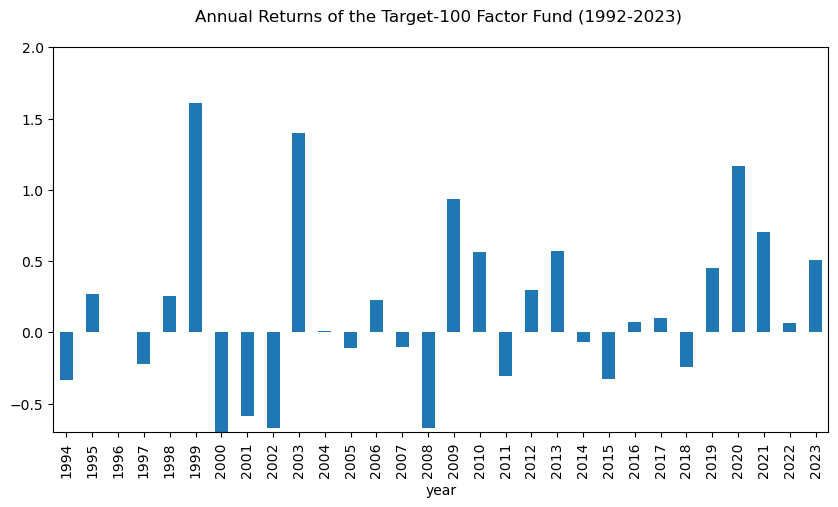

In [31]:
# Plot a bar chart for the time series
ret_fund_ann.plot(kind='bar', figsize=(10,5), x='year', y='ret_vw', ylim=(-0.7, 2.0), legend= False,\
                  title='Annual Returns of the Target-100 Factor Fund (1992-2023) \n');

In [32]:
msi = pd.read_csv('msi_6123.csv')

# Calculate the compounded return by summing up log returns and taking exp
msi['logrf'] = np.log(1+msi.rf)
rf_ann = msi.groupby(['year'])['logrf'].sum().reset_index()
rf_ann['rf'] = np.exp(rf_ann.logrf)-1
print(rf_ann)

    year     logrf        rf
0   1961  0.021361  0.021591
1   1962  0.026877  0.027241
2   1963  0.031027  0.031514
3   1964  0.034578  0.035183
4   1965  0.038855  0.039620
..   ...       ...       ...
58  2019  0.021243  0.021470
59  2020  0.004261  0.004270
60  2021  0.000402  0.000402
61  2022  0.014230  0.014332
62  2023  0.048475  0.049669

[63 rows x 3 columns]


In [35]:
# Excess annual returns for the factor fund and the benchmark index
ret_fund_ann = pd.merge(ret_fund_ann, rf_ann, on=['year'])
ret_fund_ann['exret_vw'] = ret_fund_ann.ret_vw-ret_fund_ann.rf

# Mean, Volatility, and the Sharpe ratio
print("Average annual return of Factor Fund (%):", "{:.2f}".format(ret_fund_ann.ret_vw.mean()*100))
print("Annual volatility of Factor Fund (%) (%):", "{:.2f}".format(ret_fund_ann.ret_vw.std()*100))
print("Annual Sharpe Ratio of Factor Fund:", "{:.2f}".format(ret_fund_ann.exret_vw.mean()/ret_fund_ann.exret_vw.std()))

Average annual return of Factor Fund (%): 16.18
Annual volatility of Factor Fund (%) (%): 59.01
Annual Sharpe Ratio of Factor Fund: 0.23


In [36]:
ret_indx_ann = pd.merge(ret_indx_ann, rf_ann, on=['year'])
ret_indx_ann['exret_vw'] = ret_indx_ann.ret_vw-ret_indx_ann.rf

# Mean, Volatility, and the Sharpe ratio
print("Average annual return of Benchmark Index (%):", "{:.2f}".format(ret_indx_ann.ret_vw.mean()*100))
print("Annual volatility of Benchmark Index (%) (%):", "{:.2f}".format(ret_indx_ann.ret_vw.std()*100))
print("Annual Sharpe Ratio of Benchmark Index:", "{:.2f}".format(ret_indx_ann.exret_vw.mean()/ret_indx_ann.exret_vw.std()))

Average annual return of Benchmark Index (%): 12.04
Annual volatility of Benchmark Index (%) (%): 18.19
Annual Sharpe Ratio of Benchmark Index: 0.54


In [37]:
# Past 1-year compounded returns
print("1-year compounded annual return of Factor Fund (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year==2022].logret_vw.sum())**(1))-1)*100))
print("1-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_indx_ann[ret_indx_ann.year==2022].logret_vw.sum())**(1))-1)*100))

1-year compounded annual return of Factor Fund (%): 6.41
1-year compounded annual return of Benchmark Index (%): -19.28


In [38]:
# Past 3-year compounded returns
print("3-year compounded annual return of Factor Fund (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=2020].logret_vw.sum())**(1/3))-1)*100))
print("3-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_indx_ann[ret_indx_ann.year>=2020].logret_vw.sum())**(1/3))-1)*100))

3-year compounded annual return of Factor Fund (%): 80.97
3-year compounded annual return of Benchmark Index (%): 16.71


In [39]:
# Past 5-year compounded returns
print("5-year compounded annual return of Factor Fund (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=2018].logret_vw.sum())**(1/5))-1)*100))
print("5-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_indx_ann[ret_indx_ann.year>=2018].logret_vw.sum())**(1/5))-1)*100))

5-year compounded annual return of Factor Fund (%): 45.34
5-year compounded annual return of Benchmark Index (%): 14.73


In [40]:
# Past 10-year compounded returns
print("10-year compounded annual return of Factor Fund (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=2013].logret_vw.sum())**(1/10))-1)*100))
print("10-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_indx_ann[ret_indx_ann.year>=2013].logret_vw.sum())**(1/10))-1)*100))

10-year compounded annual return of Factor Fund (%): 22.40
10-year compounded annual return of Benchmark Index (%): 15.34


In [41]:
# Past 30-year compounded returns
print("30-year compounded annual return of Factor Fund (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=1993].logret_vw.sum())**(1/30))-1)*100))
print("30-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_indx_ann[ret_indx_ann.year>=1993].logret_vw.sum())**(1/30))-1)*100))

30-year compounded annual return of Factor Fund (%): 1.02
30-year compounded annual return of Benchmark Index (%): 10.42


In [42]:
# Read the FF3 factors from the lab session
FF3 = pd.read_csv('FF3_lab.csv')

# Merge
reg_fund = pd.merge(ret_fund, FF3, on=['year','month'])

reg_fund

,year,month,nstocks,ret_vw,logret_vw,rf,MKT,SMB,HML
0,1994,1,99,0.027702,0.027325,0.002503,0.028956,0.003051,0.008388
1,1994,2,99,-0.023840,-0.024129,0.002120,-0.026327,0.027511,-0.015719
2,1994,3,98,-0.104162,-0.109996,0.002469,-0.048264,-0.011479,0.016149
3,1994,4,99,-0.021474,-0.021708,0.002711,0.006784,-0.009151,0.016975
4,1994,5,99,-0.051943,-0.053340,0.003150,0.006203,-0.020018,0.004031
...,...,...,...,...,...,...,...,...,...
355,2023,8,97,-0.112854,-0.119745,0.004537,-0.025142,-0.042465,-0.002446
356,2023,9,96,-0.049683,-0.050960,0.004267,-0.051657,-0.024624,0.013942
357,2023,10,100,-0.063462,-0.065565,0.004715,-0.033582,-0.046801,0.005730
358,2023,11,99,0.188479,0.172674,0.004424,0.087633,0.007572,-0.006505


In [43]:
# Excess fund return
reg_fund['exret_vw'] = reg_fund.ret_vw-reg_fund.rf

In [44]:
# Linear regression from statsmodels
import statsmodels.formula.api as sm

# CAPM
ols_capm = sm.ols('exret_vw ~ MKT', data=reg_fund)
est_capm = ols_capm.fit()
print(est_capm.summary())

                            OLS Regression Results                            
Dep. Variable:               exret_vw   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     519.4
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           1.13e-71
Time:                        11:41:31   Log-Likelihood:                 378.05
No. Observations:                 360   AIC:                            -752.1
Df Residuals:                     358   BIC:                            -744.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0078      0.005     -1.724      0.0

In [45]:
# FF3
ols_ff3 = sm.ols('exret_vw ~ MKT+SMB+HML', data=reg_fund)
est_ff3 = ols_ff3.fit()
print(est_ff3.summary())

                            OLS Regression Results                            
Dep. Variable:               exret_vw   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     239.3
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           5.54e-85
Time:                        11:41:31   Log-Likelihood:                 415.42
No. Observations:                 360   AIC:                            -822.8
Df Residuals:                     356   BIC:                            -807.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0067      0.004     -1.643      0.1

In [47]:
# End-of-2021 portfolio weights
top = signal2[['permno','MC','rank_beta']][(signal2.ryear==2021) & (signal2.rquarter==4)]

# VW
top['wt'] = top.MC/top.MC.sum()

# Merge with stock ticker
ticker = msf[(msf.year==2021) & (msf.month==12)][['permno','ticker']]
top = pd.merge(top, ticker, on=['permno'])

# Sort stocks from highest to lowest portfolio weight
top = top.sort_values('wt', ascending=False).reset_index(drop=True)
top.head(10)

,permno,MC,rank_beta,wt,ticker
0,87137,29.821850,64,0.160081,DVN
1,14882,19.994843,73,0.107331,CZR
2,91983,16.363406,59,0.087837,CLR
3,15069,12.783578,67,0.068621,MRO
4,12476,11.961497,76,0.064208,TRGP
5,14179,5.493775,16,0.029490,AR
6,15795,4.771276,74,0.025612,SGRY
7,62341,4.703026,46,0.025245,PDCE
8,16738,4.622239,69,0.024812,AM
9,13244,4.332045,17,0.023254,MTDR
